In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breed-recognization/milk_data_cleaned.csv
/kaggle/input/breed-recognization/Indian_bovine_breeds_80/Indian_bovine_breeds_80/Alambadi/Alambadi_019.png
/kaggle/input/breed-recognization/Indian_bovine_breeds_80/Indian_bovine_breeds_80/Alambadi/Alambadi_009.png
/kaggle/input/breed-recognization/Indian_bovine_breeds_80/Indian_bovine_breeds_80/Alambadi/Alambadi_045.png
/kaggle/input/breed-recognization/Indian_bovine_breeds_80/Indian_bovine_breeds_80/Alambadi/Alambadi_078.png
/kaggle/input/breed-recognization/Indian_bovine_breeds_80/Indian_bovine_breeds_80/Alambadi/Alambadi_013.png
/kaggle/input/breed-recognization/Indian_bovine_breeds_80/Indian_bovine_breeds_80/Alambadi/Alambadi_008.png
/kaggle/input/breed-recognization/Indian_bovine_breeds_80/Indian_bovine_breeds_80/Alambadi/Alambadi_007.jpg
/kaggle/input/breed-recognization/Indian_bovine_breeds_80/Indian_bovine_breeds_80/Alambadi/Alambadi_017.png
/kaggle/input/breed-recognization/Indian_bovine_breeds_80/Indian_bovine_breeds_8

# BLOCK 1 – IMPORTS
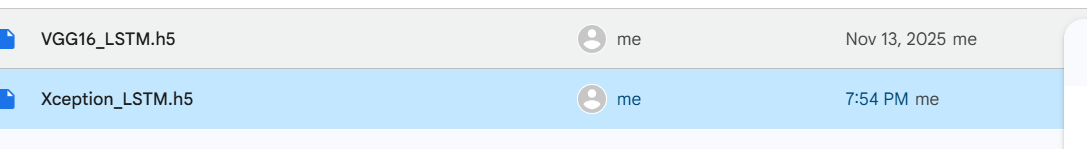

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, LSTM, Conv2D, MaxPooling2D, GlobalAveragePooling2D, concatenate
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, Xception, MobileNetV2, DenseNet121, EfficientNetB4
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
)


2025-11-17 15:31:55.041048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763393515.302402      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763393515.372363      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# BLOCK 2 – PATHS

In [3]:
IMAGE_PATH = "/kaggle/input/breed-recognization/Indian_bovine_breeds_80/Indian_bovine_breeds_80"
CSV_PATH   = "/kaggle/input/breed-recognization/milk_data_cleaned.csv"


# BLOCK 3 – LOAD CSV + CHECK BASIC INFO

In [4]:
df = pd.read_csv(CSV_PATH)
print("🔹 CSV Loaded\n")
print(df.head())

num_classes = df["Breed"].nunique()
print(f"\n✅ Number of Breed Classes: {num_classes}")


🔹 CSV Loaded

             ID     Breed      Date  \
0  Alambadi_001  Alambadi  1/4/2023   
1  Alambadi_001  Alambadi  2/4/2023   
2  Alambadi_001  Alambadi  3/4/2023   
3  Alambadi_001  Alambadi  4/4/2023   
4  Alambadi_001  Alambadi  5/4/2023   

                                          Image_Path  Milk_Yield_L  Fat_pct  \
0  /kaggle/input/breed-recognization/Indian_bovin...          6.14     4.46   
1  /kaggle/input/breed-recognization/Indian_bovin...          5.40     4.28   
2  /kaggle/input/breed-recognization/Indian_bovin...          5.71     4.44   
3  /kaggle/input/breed-recognization/Indian_bovin...          6.62     4.64   
4  /kaggle/input/breed-recognization/Indian_bovin...          6.05     4.76   

   Protein_pct  Lactose_pct  SNF_pct  Total_Solids_pct  
0         3.55         4.74     9.00             13.46  
1         3.70         4.69     9.09             13.38  
2         3.53         4.77     9.00             13.44  
3         3.68         4.85     9.23            

# BLOCK 4 – IMAGE ENHANCEMENT (CLAHE)

In [5]:
def enhance_image(path):
    img = cv2.imread(path)
    if img is None:
        return None
    
    img = cv2.resize(img, (224, 224))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    final = final.astype("float32") / 255.0
    
    return final


# BLOCK 5 – LOAD IMAGE FROM CSV PATH

In [6]:
def load_image(rel_path):
    full_path = os.path.join(IMAGE_PATH, rel_path)
    return enhance_image(full_path)


# BLOCK 6 – NORMALIZE MILK TRAITS

In [7]:
milk_features = [
    "Milk_Yield_L","Fat_pct","Protein_pct",
    "Lactose_pct","SNF_pct","Total_Solids_pct"
]

scaler = MinMaxScaler()
df[milk_features] = scaler.fit_transform(df[milk_features])


# BLOCK 7 – CREATE 29-DAY SEQUENCES

In [8]:
def create_sequences(group, seq_len=29):
    group = group.sort_values("Date")
    X_seq, y_seq = [], []
    data = group[milk_features].values
    
    for i in range(len(data) - seq_len):
        X_seq.append(data[i:i+seq_len])
        y_seq.append(data[i+seq_len])
    
    return np.array(X_seq), np.array(y_seq)


# BLOCK 8 – BUILD DATASET

In [9]:
X_img, X_lstm, y_cls, y_reg = [], [], [], []

for ID, group in tqdm(df.groupby("ID")):
    img_path = group["Image_Path"].iloc[0]
    img_data = load_image(img_path)
    
    if img_data is None:
        print(f"⚠️ Skipped corrupted: {img_path}")
        continue
    
    seqX, seqY = create_sequences(group, seq_len=29)
    
    for i in range(len(seqX)):
        X_img.append(img_data)
        X_lstm.append(seqX[i])
        y_reg.append(seqY[i])
        y_cls.append(group["Breed"].iloc[0])

X_img = np.array(X_img)
X_lstm = np.array(X_lstm)
y_reg = np.array(y_reg)
y_cls = np.array(y_cls)

print(f"\n✅ Dataset Built | Images = {len(X_img)} | Sequences = {len(X_lstm)}")


100%|█████████▉| 2957/2961 [01:19<00:00, 22.73it/s]

⚠️ Skipped corrupted: /kaggle/input/breed-recognization/Indian_bovine_breeds_80/Indian_bovine_breeds_80/Vechur/Vechur_077 (1).png


100%|██████████| 2961/2961 [01:19<00:00, 37.32it/s]



✅ Dataset Built | Images = 2960 | Sequences = 2960


# BLOCK 9 – LABEL ENCODING + TRAIN/TEST SPLIT# 

In [10]:
le = LabelEncoder()
y_cls = le.fit_transform(y_cls)

Ximg_train, Ximg_test, Xlstm_train, Xlstm_test, ycls_train, ycls_test, yreg_train, yreg_test = train_test_split(
    X_img, X_lstm, y_cls, y_reg,
    test_size=0.2, random_state=42, stratify=y_cls
)


# BLOCK 10 – FEATURE EXTRACTORS

In [11]:
def get_feature_extractor(name):
    input_shape = (224,224,3)

    if name == "ResNet50":
        return ResNet50(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")
    if name == "VGG16":
        return VGG16(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")
    if name == "VGG19":
        return VGG19(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")
    if name == "Xception":
        return Xception(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")
    if name == "MobileNetV2":
        return MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")
    if name == "EfficientNetB4":
        return EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")
    if name == "DenseNet121":
        return DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape, pooling="avg")

    # Custom CNN
    inp = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu')(inp)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    return Model(inp, x)


# BLOCK 11 – HYBRID MODEL (CNN + LSTM)

In [12]:
def build_hybrid_model(base_model, seq_len=29, milk_features=6, num_classes=num_classes):
    
    base_model.trainable = False

    img_input = Input(shape=(224,224,3))
    seq_input = Input(shape=(seq_len, milk_features))

    x = base_model(img_input, training=False)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)

    t = LSTM(128)(seq_input)
    t = Dense(128, activation='relu')(t)
    t = Dropout(0.3)(t)

    merged = concatenate([x, t])

    cls_out = Dense(num_classes, activation='softmax', name="breed_output")(merged)
    reg_out = Dense(milk_features, activation='linear', name="milk_output")(merged)

    model = Model([img_input, seq_input], [cls_out, reg_out])

    model.compile(
        optimizer="adam",
        loss={"breed_output":"sparse_categorical_crossentropy",
              "milk_output":"mse"},
        metrics={"breed_output":"accuracy"}
    )

    return model


# BLOCK 12 – TRAINING FUNCTION (WITH EARLY STOPPING)

In [13]:
def train_model(model, name):

    es = EarlyStopping(
        monitor="val_breed_output_accuracy",
        patience=5,
        mode="max",
        restore_best_weights=True,
        verbose=1  # shows: "Restoring model weights from the end of the best epoch"
    )

    history = model.fit(
        [Ximg_train, Xlstm_train],
        {"breed_output":ycls_train, "milk_output":yreg_train},
        validation_split=0.2,
        epochs=30,
        batch_size=16,
        callbacks=[es],
        verbose=1
    )

    model.save(f"{name}.h5")
    print(f"✅ Saved: {name}.h5")
    
    return history


# BLOCK 13 – TRAIN ALL 8 FEATURE EXTRACTORS

In [14]:
feature_extractors = [
    "ResNet50","VGG16","VGG19","Xception",
    "MobileNetV2","EfficientNetB4","DenseNet121","CustomCNN"
]

models = {}
histories = {}

for feat in feature_extractors:
    print(f"\n🚀 Training {feat} + LSTM\n")
    
    base = get_feature_extractor(feat)
    model = build_hybrid_model(base)
    history = train_model(model, feat + "_LSTM")

    models[feat] = model
    histories[feat] = history



🚀 Training ResNet50 + LSTM



I0000 00:00:1763393614.711177      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763393614.711804      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


I0000 00:00:1763393628.923399      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


119/119 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - breed_output_accuracy: 0.0513 - breed_output_loss: 3.4825 - loss: 3.6765 - milk_output_loss: 0.1703 - val_breed_output_accuracy: 0.1835 - val_breed_output_loss: 2.3855 - val_loss: 2.4110 - val_milk_output_loss: 0.0168
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - breed_output_accuracy: 0.1983 - breed_output_loss: 2.2509 - loss: 2.3437 - milk_output_loss: 0.0840 - val_breed_output_accuracy: 0.1498 - val_breed_output_loss: 2.5048 - val_loss: 2.5333 - val_milk_output_loss: 0.0193
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - breed_output_accuracy: 0.2106 - breed_output_loss: 2.2222 - loss: 2.2668 - milk_output_loss: 0.0375 - val_breed_output_accuracy: 0.3481 - val_breed_output_loss: 1.7541 - val_loss: 1.7712 - val_milk_output_loss: 0.0108
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - breed_output_accuracy: 0.3673 - breed_output_loss: 1.5701 - loss: 1.5997 - milk_output_loss: 0.0235 - val_breed_output_accuracy: 0.5

✅ Saved: ResNet50_LSTM.h5

🚀 Training VGG16 + LSTM

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - breed_output_accuracy: 0.0723 - breed_output_loss: 3.4690 - loss: 3.6386 - milk_output_loss: 0.1419 - val_breed_output_accuracy: 0.1899 - val_breed_output_loss: 2.7376 - val_loss: 2.7773 - val_milk_output_loss: 0.0205
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - breed_output_accuracy: 0.1848 - breed_output_loss: 2.5306 - loss: 2.6324 - milk_output_loss: 0.0813 - val_breed_output_accuracy: 0.3291 - val_breed_output_loss: 1.8409 - val_loss: 1.8714 - val_milk_output_loss: 0.0144
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - breed_output_accuracy: 0.3377 - breed_output_loss: 1.8020 - loss: 1.8815 - milk_output_loss: 0.0601 - val_breed_output_accuracy: 0.3987 - val_breed_output_loss: 1.5378 - val_loss: 1.5649 - val_milk_output_loss: 0.0132
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - breed_output_accur

✅ Saved: VGG16_LSTM.h5

🚀 Training VGG19 + LSTM

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - breed_output_accuracy: 0.0484 - breed_output_loss: 3.5139 - loss: 3.6640 - milk_output_loss: 0.1222 - val_breed_output_accuracy: 0.1878 - val_breed_output_loss: 2.6004 - val_loss: 2.6364 - val_milk_output_loss: 0.0180
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - breed_output_accuracy: 0.2080 - breed_output_loss: 2.4539 - loss: 2.5593 - milk_output_loss: 0.0848 - val_breed_output_accuracy: 0.4114 - val_breed_output_loss: 1.8101 - val_loss: 1.8424 - val_milk_output_loss: 0.0160
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - breed_output_accuracy: 0.3737 - breed_output_loss: 1.7541 - loss: 1.8385 - milk_output_loss: 0.0654 - val_breed_output_accuracy: 0.2722 - val_breed_output_loss: 1.9469 - val_loss: 1.9808 - val_milk_output_loss: 0.0119
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - breed_output_accur

✅ Saved: VGG19_LSTM.h5

🚀 Training Xception + LSTM

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - breed_output_accuracy: 0.0923 - breed_output_loss: 3.4382 - loss: 3.6352 - milk_output_loss: 0.1522 - val_breed_output_accuracy: 0.3460 - val_breed_output_loss: 2.2003 - val_loss: 2.2863 - val_milk_output_loss: 0.0446
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - breed_output_accuracy: 0.3576 - breed_output_loss: 1.9808 - loss: 2.1620 - milk_output_loss: 0.1390 - val_breed_output_accuracy: 0.4979 - val_breed_output_loss: 1.4669 - val_loss: 1.5344 - val_milk_output_loss: 0.0255
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - breed_output_accuracy: 0.5736 - breed_output_loss: 1.3053 - loss: 1.4309 - milk_output_loss: 0.0849 - val_breed_output_accuracy: 0.5359 - val_breed_output_loss: 1.3273 - val_loss: 1.3908 - val_milk_output_loss: 0.0198
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - breed_output_ac

✅ Saved: Xception_LSTM.h5

🚀 Training MobileNetV2 + LSTM

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - breed_output_accuracy: 0.0784 - breed_output_loss: 3.4818 - loss: 3.7584 - milk_output_loss: 0.2344 - val_breed_output_accuracy: 0.2848 - val_breed_output_loss: 2.1554 - val_loss: 2.2381 - val_milk_output_loss: 0.0455
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - breed_output_accuracy: 0.3164 - breed_output_loss: 2.0248 - loss: 2.2087 - milk_output_loss: 0.1434 - val_breed_output_accuracy: 0.5211 - val_breed_output_loss: 1.4064 - val_loss: 1.4747 - val_milk_output_loss: 0.0275
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - breed_output_accuracy: 0.5317 - breed_output_loss: 1.3162 - loss: 1.4419 - milk_output_loss: 0.0859 - val_breed_output_accuracy: 0.4641 - val_breed_output_loss: 1.5953 - val_loss: 1.6595 - val_milk_output_loss: 0.0243
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - breed_output_accur

✅ Saved: MobileNetV2_LSTM.h5

🚀 Training EfficientNetB4 + LSTM

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


E0000 00:00:1763394622.436476      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


119/119 ━━━━━━━━━━━━━━━━━━━━ 42s 182ms/step - breed_output_accuracy: 0.0432 - breed_output_loss: 3.4643 - loss: 3.5700 - milk_output_loss: 0.0699 - val_breed_output_accuracy: 0.2384 - val_breed_output_loss: 2.3472 - val_loss: 2.3882 - val_milk_output_loss: 0.0166
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - breed_output_accuracy: 0.2099 - breed_output_loss: 2.2288 - loss: 2.3386 - milk_output_loss: 0.0828 - val_breed_output_accuracy: 0.3101 - val_breed_output_loss: 1.7643 - val_loss: 1.8028 - val_milk_output_loss: 0.0173
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - breed_output_accuracy: 0.2900 - breed_output_loss: 1.8693 - loss: 1.9308 - milk_output_loss: 0.0390 - val_breed_output_accuracy: 0.3713 - val_breed_output_loss: 1.4772 - val_loss: 1.5028 - val_milk_output_loss: 0.0087
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - breed_output_accuracy: 0.4672 - breed_output_loss: 1.3387 - loss: 1.3811 - milk_output_loss: 0.0235 - val_breed_output_accuracy: 

✅ Saved: EfficientNetB4_LSTM.h5

🚀 Training DenseNet121 + LSTM

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - breed_output_accuracy: 0.0588 - breed_output_loss: 3.5693 - loss: 3.9408 - milk_output_loss: 0.3367 - val_breed_output_accuracy: 0.1730 - val_breed_output_loss: 2.5226 - val_loss: 2.5759 - val_milk_output_loss: 0.0287
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - breed_output_accuracy: 0.2352 - breed_output_loss: 2.2599 - loss: 2.3974 - milk_output_loss: 0.1129 - val_breed_output_accuracy: 0.3143 - val_breed_output_loss: 1.8927 - val_loss: 1.9334 - val_milk_output_loss: 0.0201
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - breed_output_accuracy: 0.3810 - breed_output_loss: 1.7524 - loss: 1.8472 - milk_output_loss: 0.0722 - val_breed_output_accuracy: 0.5274 - val_breed_output_loss: 1.3112 - val_loss: 1.3535 - val_milk_output_loss: 0.0186
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - breed_

✅ Saved: DenseNet121_LSTM.h5

🚀 Training CustomCNN + LSTM

Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - breed_output_accuracy: 0.0262 - breed_output_loss: 6.5520 - loss: 33.3020 - milk_output_loss: 26.6709 - val_breed_output_accuracy: 0.0633 - val_breed_output_loss: 2.7807 - val_loss: 2.8860 - val_milk_output_loss: 0.0263
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - breed_output_accuracy: 0.1216 - breed_output_loss: 2.6238 - loss: 2.7981 - milk_output_loss: 0.0954 - val_breed_output_accuracy: 0.2089 - val_breed_output_loss: 2.1674 - val_loss: 2.2481 - val_milk_output_loss: 0.0158
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - breed_output_accuracy: 0.1835 - breed_output_loss: 2.1268 - loss: 2.2464 - milk_output_loss: 0.0549 - val_breed_output_accuracy: 0.3207 - val_breed_output_loss: 1.6931 - val_loss: 1.7618 - val_milk_output_loss: 0.0112
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - breed_output_accuracy: 0.2514 - breed_output_loss: 1.9041 - loss

✅ Saved: CustomCNN_LSTM.h5


# BLOCK 14 – REGRESSION METRICS

In [15]:
def regression_metrics(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mape, mae, rmse


# BLOCK 15 – Confusion Matrix Code

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=True
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# BLOCK 16 – MODEL EVALUATION


🔷 RESULTS FOR ResNet50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step


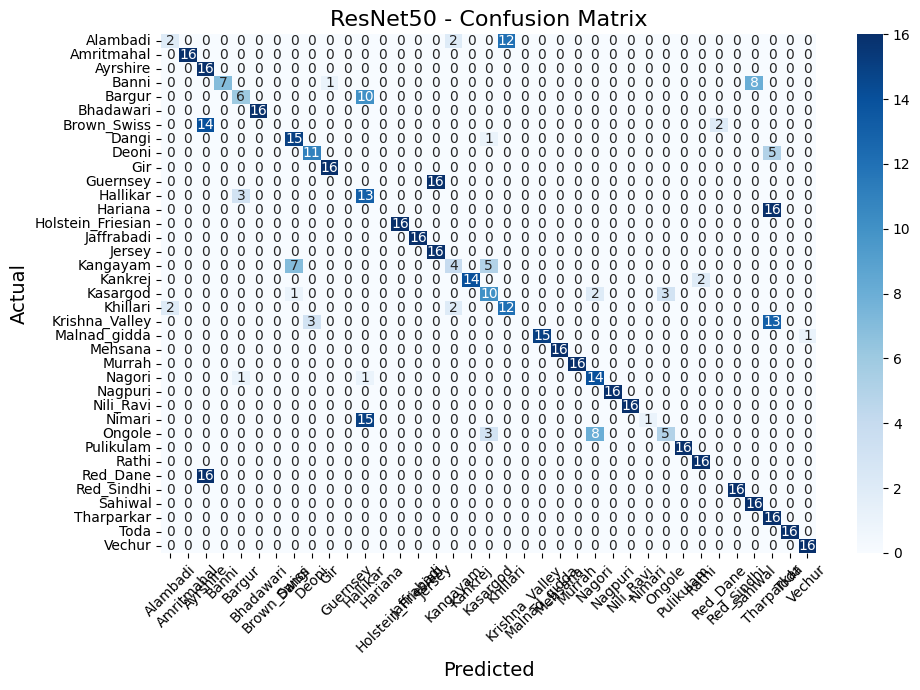


📌 Classification Report
                   precision    recall  f1-score   support

         Alambadi       0.50      0.12      0.20        16
       Amritmahal       1.00      1.00      1.00        16
         Ayrshire       0.35      1.00      0.52        16
            Banni       1.00      0.44      0.61        16
           Bargur       0.60      0.38      0.46        16
        Bhadawari       1.00      1.00      1.00        16
      Brown_Swiss       0.00      0.00      0.00        16
            Dangi       0.65      0.94      0.77        16
            Deoni       0.79      0.69      0.73        16
              Gir       0.94      1.00      0.97        16
         Guernsey       0.00      0.00      0.00        16
         Hallikar       0.33      0.81      0.47        16
          Hariana       0.00      0.00      0.00        16
Holstein_Friesian       1.00      1.00      1.00        16
       Jaffrabadi       1.00      1.00      1.00        16
           Jersey       0.50  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step


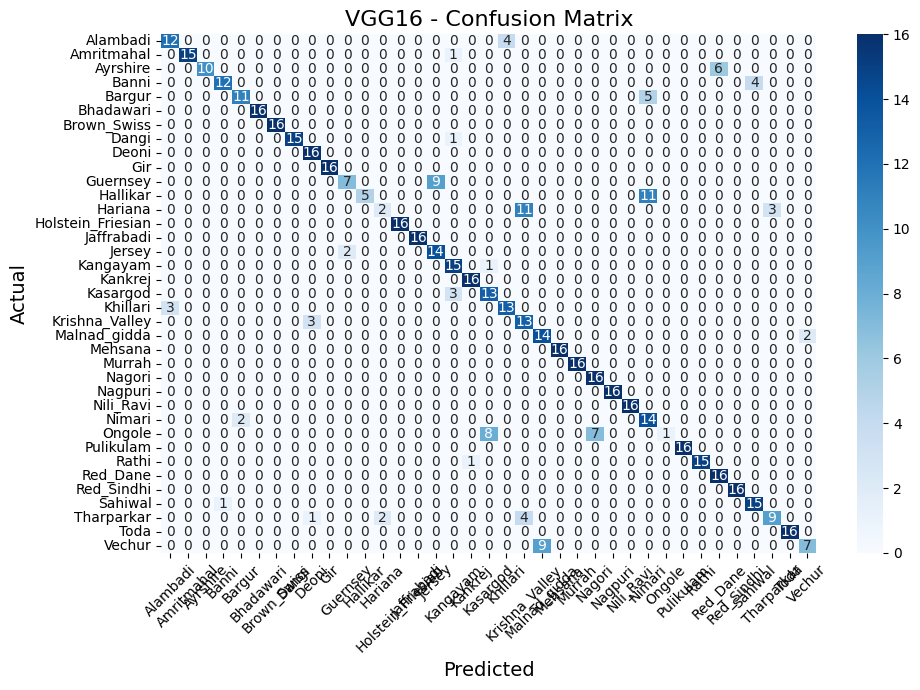


📌 Classification Report
                   precision    recall  f1-score   support

         Alambadi       0.80      0.75      0.77        16
       Amritmahal       1.00      0.94      0.97        16
         Ayrshire       1.00      0.62      0.77        16
            Banni       0.92      0.75      0.83        16
           Bargur       0.85      0.69      0.76        16
        Bhadawari       1.00      1.00      1.00        16
      Brown_Swiss       1.00      1.00      1.00        16
            Dangi       1.00      0.94      0.97        16
            Deoni       0.80      1.00      0.89        16
              Gir       1.00      1.00      1.00        16
         Guernsey       0.78      0.44      0.56        16
         Hallikar       1.00      0.31      0.48        16
          Hariana       0.50      0.12      0.20        16
Holstein_Friesian       1.00      1.00      1.00        16
       Jaffrabadi       1.00      1.00      1.00        16
           Jersey       0.61  

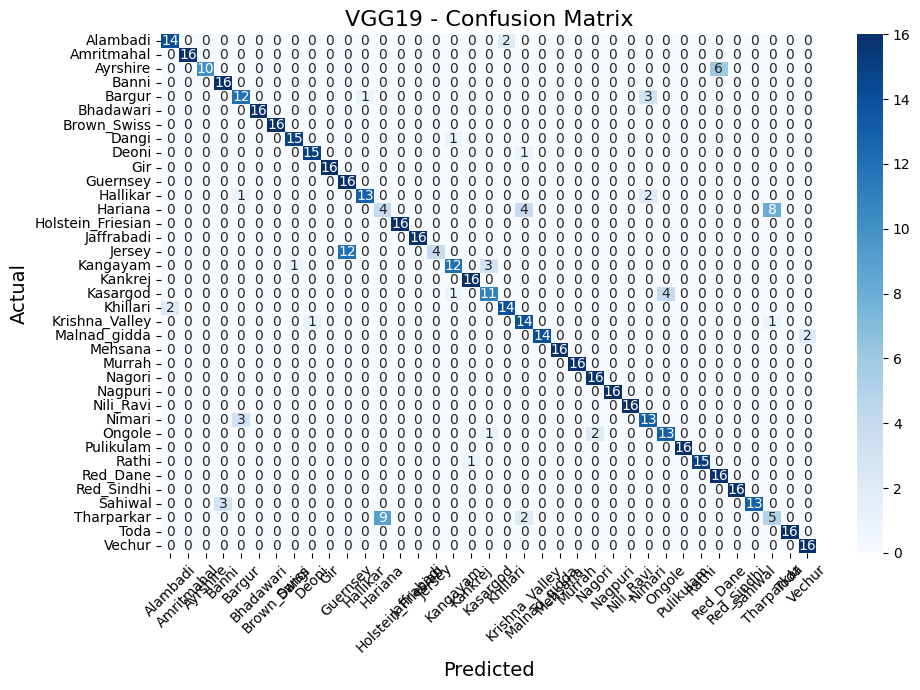


📌 Classification Report
                   precision    recall  f1-score   support

         Alambadi       0.88      0.88      0.88        16
       Amritmahal       1.00      1.00      1.00        16
         Ayrshire       1.00      0.62      0.77        16
            Banni       0.84      1.00      0.91        16
           Bargur       0.75      0.75      0.75        16
        Bhadawari       1.00      1.00      1.00        16
      Brown_Swiss       1.00      1.00      1.00        16
            Dangi       0.94      0.94      0.94        16
            Deoni       0.94      0.94      0.94        16
              Gir       1.00      1.00      1.00        16
         Guernsey       0.57      1.00      0.73        16
         Hallikar       0.93      0.81      0.87        16
          Hariana       0.31      0.25      0.28        16
Holstein_Friesian       1.00      1.00      1.00        16
       Jaffrabadi       1.00      1.00      1.00        16
           Jersey       1.00  

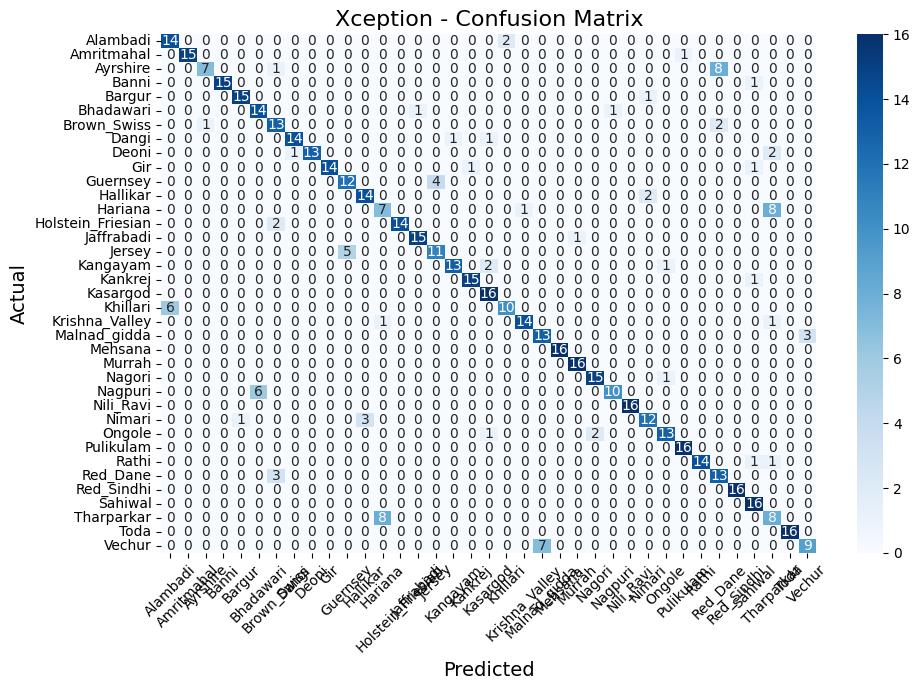


📌 Classification Report
                   precision    recall  f1-score   support

         Alambadi       0.70      0.88      0.78        16
       Amritmahal       1.00      0.94      0.97        16
         Ayrshire       0.88      0.44      0.58        16
            Banni       1.00      0.94      0.97        16
           Bargur       0.94      0.94      0.94        16
        Bhadawari       0.70      0.88      0.78        16
      Brown_Swiss       0.68      0.81      0.74        16
            Dangi       0.93      0.88      0.90        16
            Deoni       1.00      0.81      0.90        16
              Gir       1.00      0.88      0.93        16
         Guernsey       0.71      0.75      0.73        16
         Hallikar       0.82      0.88      0.85        16
          Hariana       0.44      0.44      0.44        16
Holstein_Friesian       1.00      0.88      0.93        16
       Jaffrabadi       0.94      0.94      0.94        16
           Jersey       0.73  

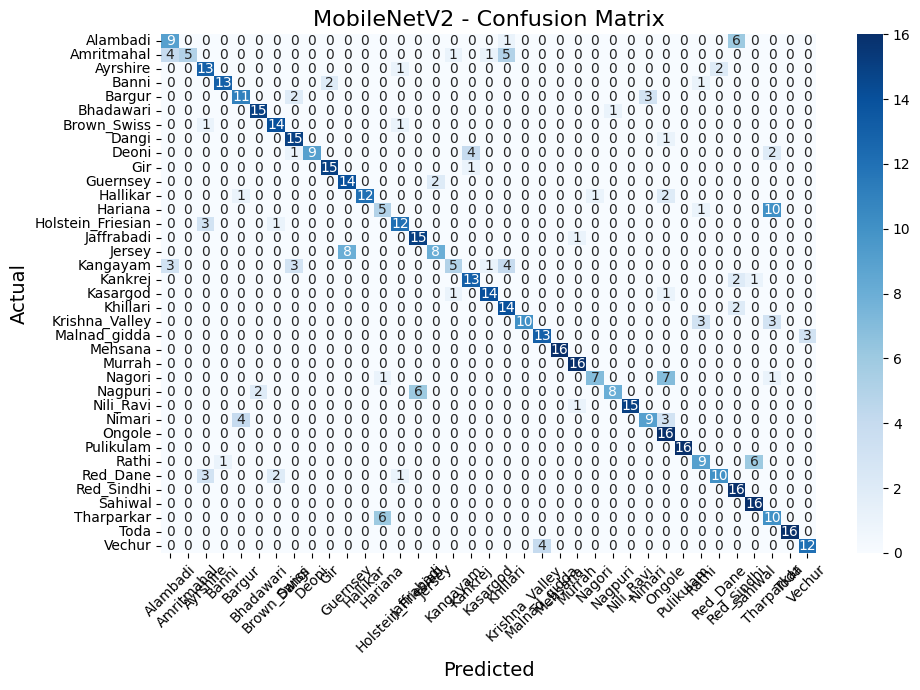


📌 Classification Report
                   precision    recall  f1-score   support

         Alambadi       0.56      0.56      0.56        16
       Amritmahal       1.00      0.31      0.48        16
         Ayrshire       0.65      0.81      0.72        16
            Banni       0.93      0.81      0.87        16
           Bargur       0.69      0.69      0.69        16
        Bhadawari       0.88      0.94      0.91        16
      Brown_Swiss       0.82      0.88      0.85        16
            Dangi       0.71      0.94      0.81        16
            Deoni       1.00      0.56      0.72        16
              Gir       0.88      0.94      0.91        16
         Guernsey       0.64      0.88      0.74        16
         Hallikar       1.00      0.75      0.86        16
          Hariana       0.42      0.31      0.36        16
Holstein_Friesian       0.80      0.75      0.77        16
       Jaffrabadi       0.71      0.94      0.81        16
           Jersey       0.80  

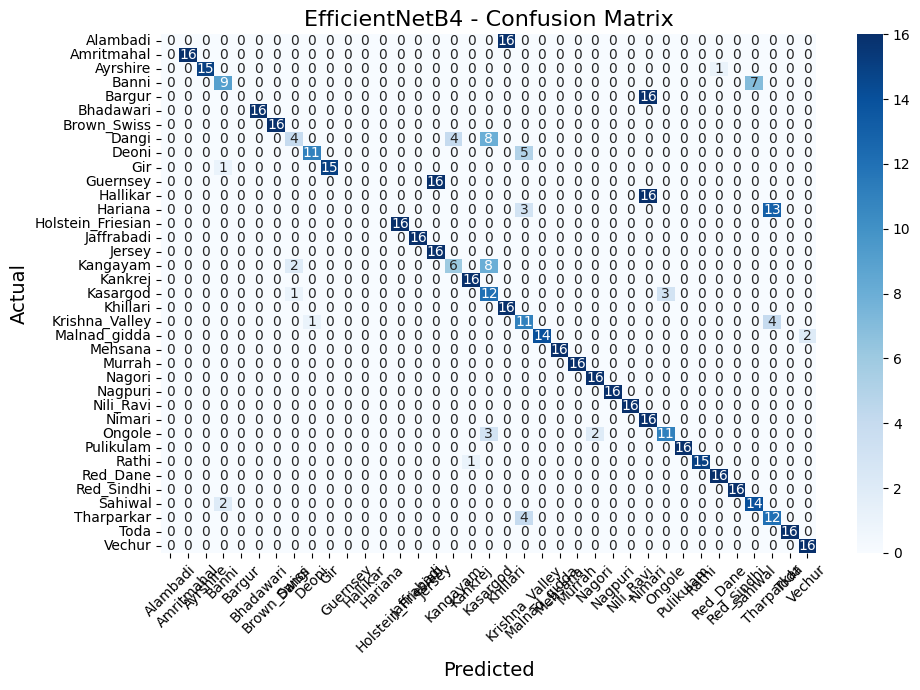


📌 Classification Report
                   precision    recall  f1-score   support

         Alambadi       0.00      0.00      0.00        16
       Amritmahal       1.00      1.00      1.00        16
         Ayrshire       1.00      0.94      0.97        16
            Banni       0.75      0.56      0.64        16
           Bargur       0.00      0.00      0.00        16
        Bhadawari       1.00      1.00      1.00        16
      Brown_Swiss       1.00      1.00      1.00        16
            Dangi       0.57      0.25      0.35        16
            Deoni       0.92      0.69      0.79        16
              Gir       1.00      0.94      0.97        16
         Guernsey       0.00      0.00      0.00        16
         Hallikar       0.00      0.00      0.00        16
          Hariana       0.00      0.00      0.00        16
Holstein_Friesian       1.00      1.00      1.00        16
       Jaffrabadi       1.00      1.00      1.00        16
           Jersey       0.50  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step


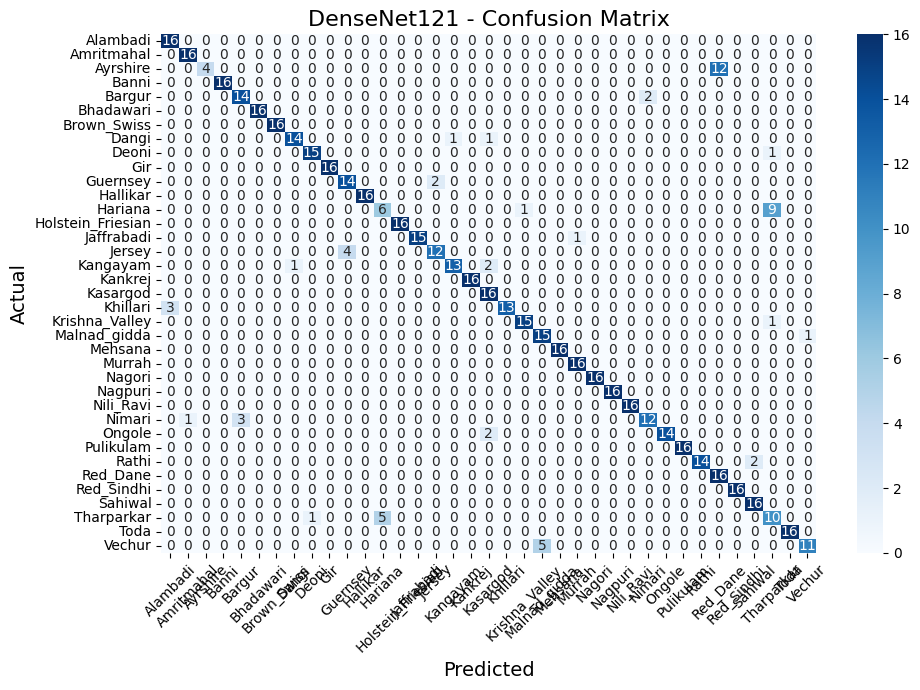


📌 Classification Report
                   precision    recall  f1-score   support

         Alambadi       0.84      1.00      0.91        16
       Amritmahal       0.94      1.00      0.97        16
         Ayrshire       1.00      0.25      0.40        16
            Banni       1.00      1.00      1.00        16
           Bargur       0.82      0.88      0.85        16
        Bhadawari       1.00      1.00      1.00        16
      Brown_Swiss       1.00      1.00      1.00        16
            Dangi       0.93      0.88      0.90        16
            Deoni       0.94      0.94      0.94        16
              Gir       1.00      1.00      1.00        16
         Guernsey       0.78      0.88      0.82        16
         Hallikar       1.00      1.00      1.00        16
          Hariana       0.55      0.38      0.44        16
Holstein_Friesian       1.00      1.00      1.00        16
       Jaffrabadi       1.00      0.94      0.97        16
           Jersey       0.86  

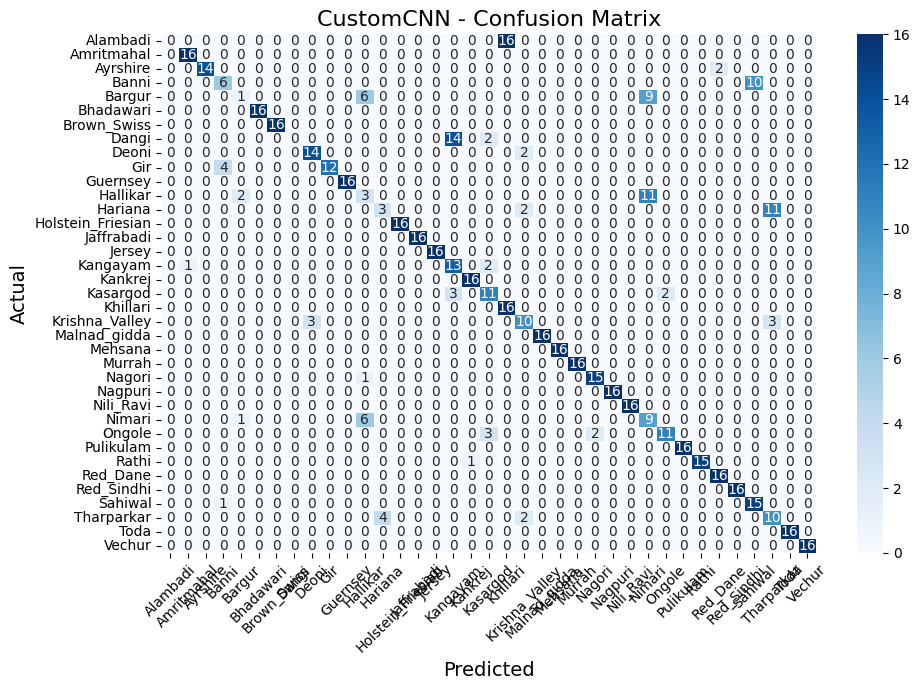


📌 Classification Report
                   precision    recall  f1-score   support

         Alambadi       0.00      0.00      0.00        16
       Amritmahal       0.94      1.00      0.97        16
         Ayrshire       1.00      0.88      0.93        16
            Banni       0.55      0.38      0.44        16
           Bargur       0.25      0.06      0.10        16
        Bhadawari       1.00      1.00      1.00        16
      Brown_Swiss       1.00      1.00      1.00        16
            Dangi       0.00      0.00      0.00        16
            Deoni       0.82      0.88      0.85        16
              Gir       1.00      0.75      0.86        16
         Guernsey       1.00      1.00      1.00        16
         Hallikar       0.19      0.19      0.19        16
          Hariana       0.43      0.19      0.26        16
Holstein_Friesian       1.00      1.00      1.00        16
       Jaffrabadi       1.00      1.00      1.00        16
           Jersey       1.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

def regression_metrics(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mape, mae, rmse


for feat, model in models.items():

    print(f"\n======================")
    print(f"🔷 RESULTS FOR {feat}")
    print(f"======================")

    # Predictions
    pred_cls, pred_reg = model.predict([Ximg_test, Xlstm_test])
    y_pred = np.argmax(pred_cls, axis=1)

    # 🔥 Confusion Matrix Plot
    plot_confusion_matrix(
        ycls_test,
        y_pred,
        class_names=le.classes_,
        title=f"{feat} - Confusion Matrix"
    )

    # 📌 Classification Report
    print("\n📌 Classification Report")
    print(classification_report(ycls_test, y_pred, target_names=le.classes_))

    # 📌 Milk Regression Metrics
    mape, mae, rmse = regression_metrics(yreg_test, pred_reg)
    print("\n📌 1-Day Future Milk Trait Prediction:")
    print(f"   🔸 MAPE (%) : {mape:.2f}%")
    print(f"   🔸 MAE      : {mae:.4f}")
    print(f"   🔸 RMSE     : {rmse:.4f}")


# BLOCK 17 – TRAINING CURVES (PLOTS)

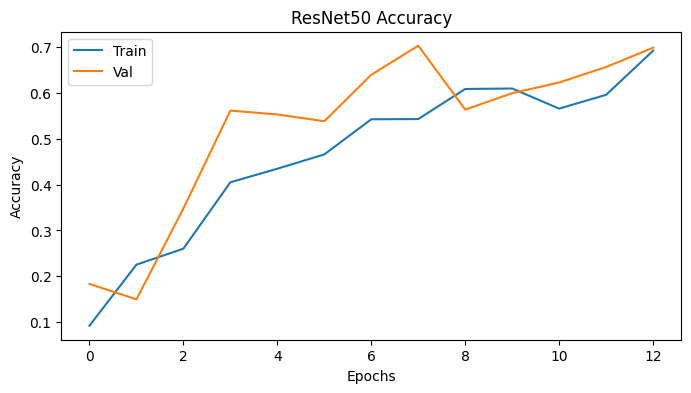

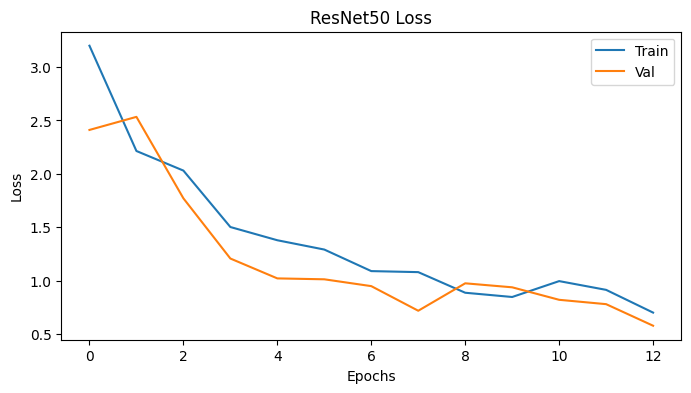

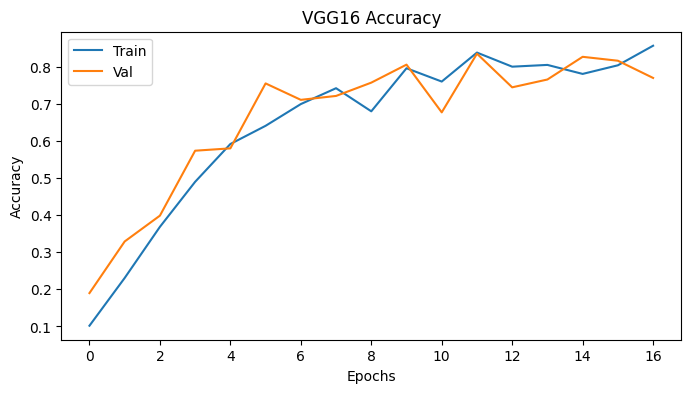

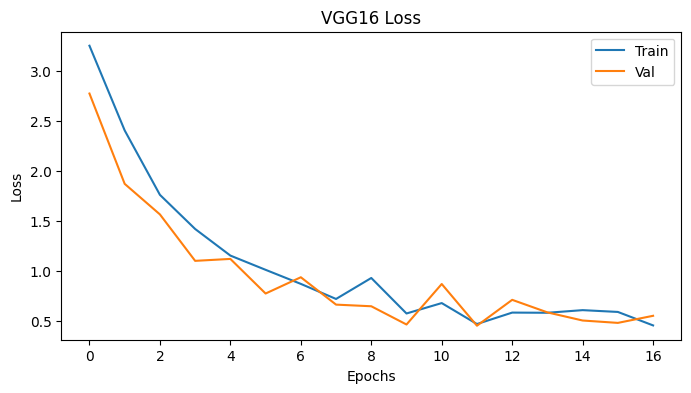

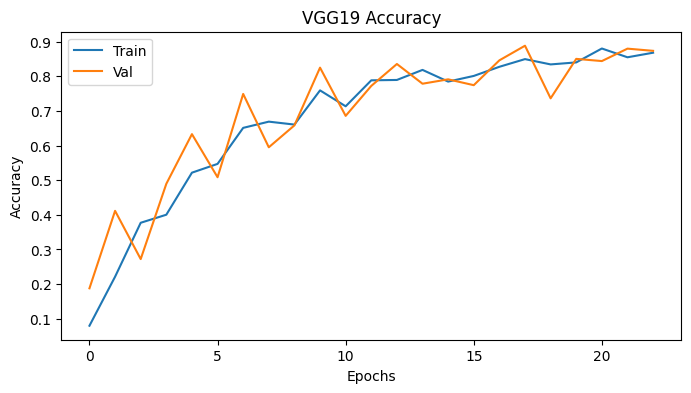

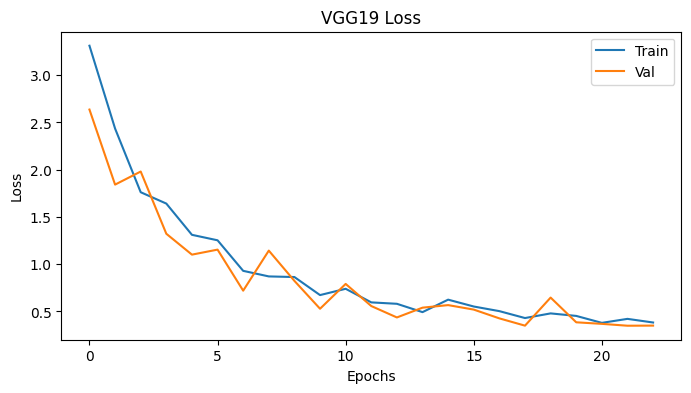

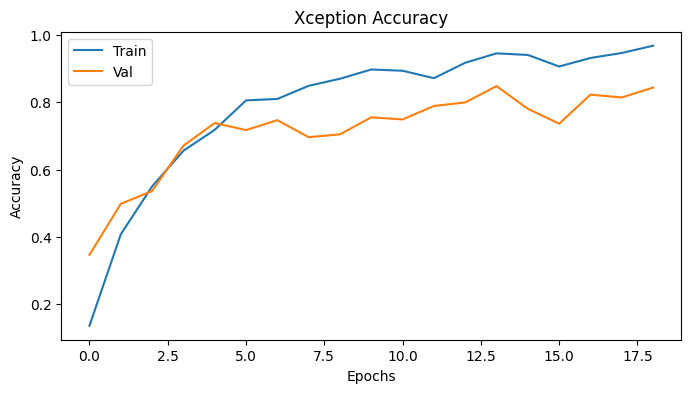

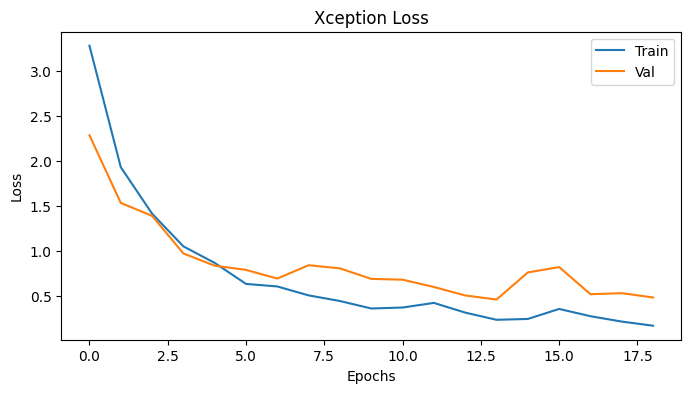

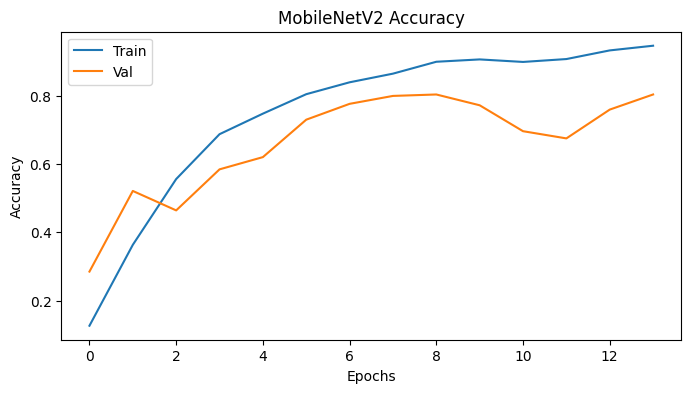

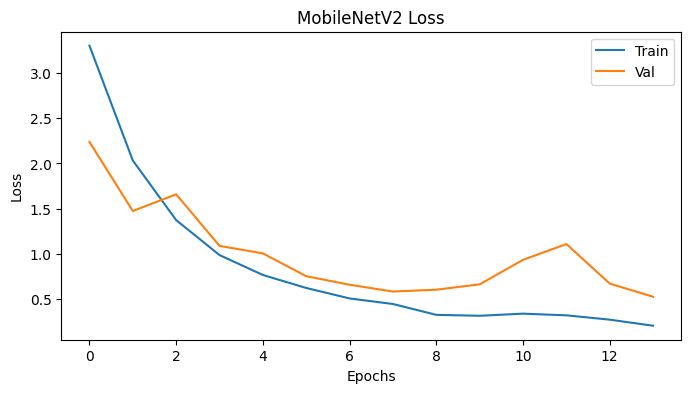

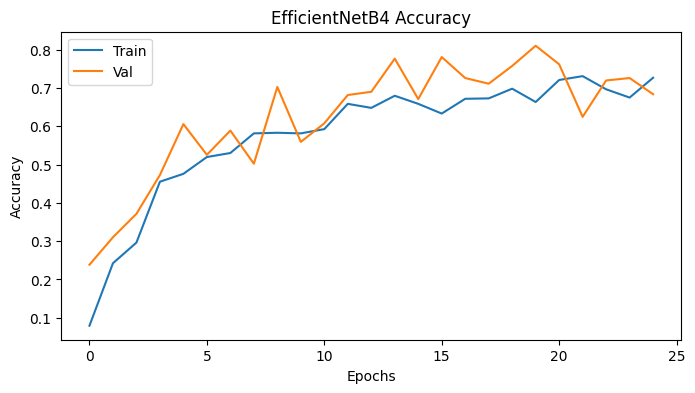

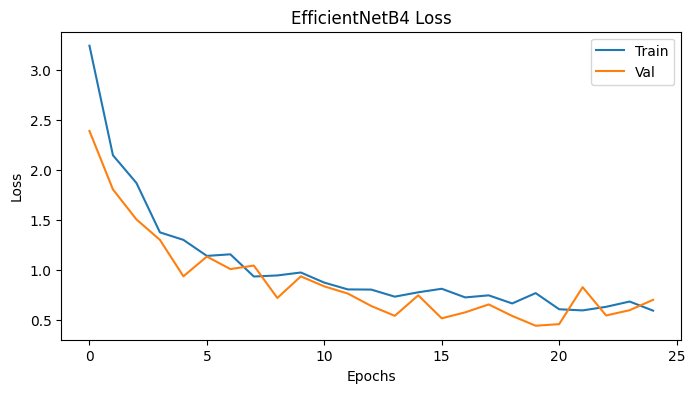

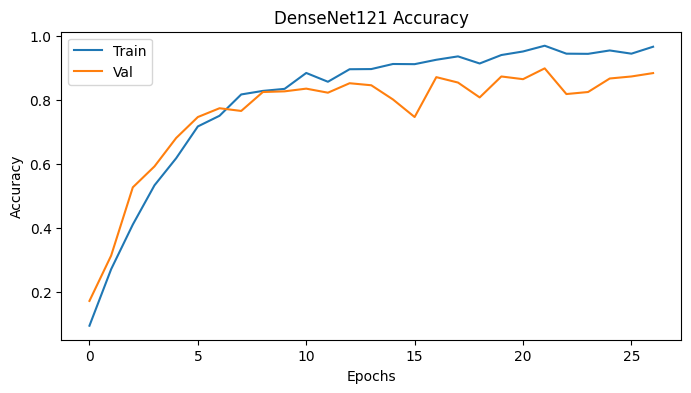

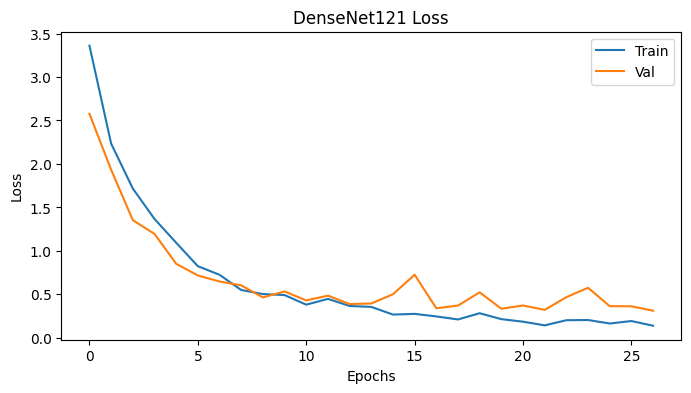

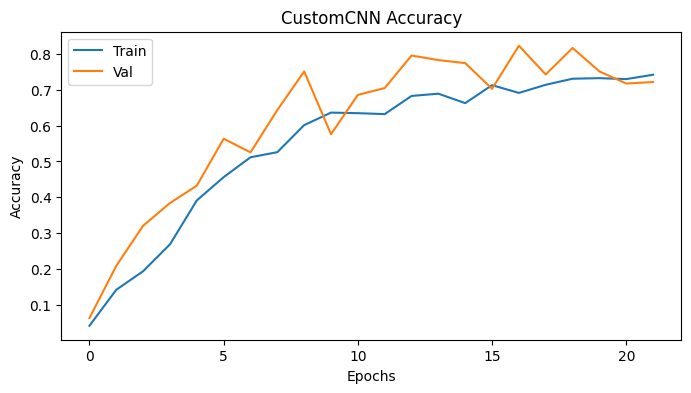

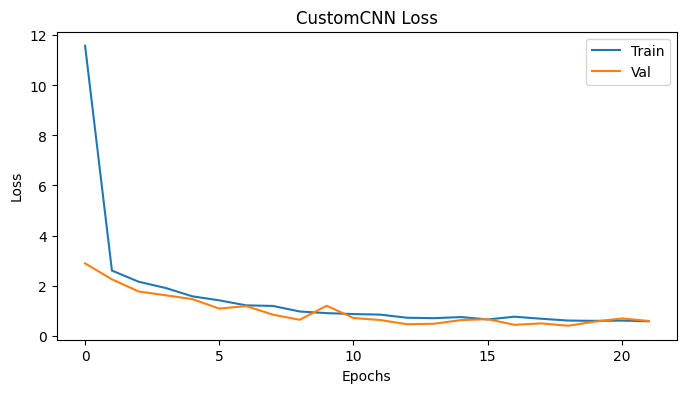

In [18]:
def plot_curves(history, title):

    plt.figure(figsize=(8,4))
    plt.plot(history.history['breed_output_accuracy'])
    plt.plot(history.history['val_breed_output_accuracy'])
    plt.title(f"{title} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train","Val"])
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f"{title} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train","Val"])
    plt.show()

for feat, hist in histories.items():
    plot_curves(hist, feat)
